<div align="center">
<a href="https://vbti.nl"><img src="https://docs.google.com/uc?export=download&id=1DdCGllL51O5wBuiI0rwygofKx3YIDPHX" width="400"></a>
</div>

# Cifar10 dataset object classification
Convolution Neural Networks are a particular type of Artificial Neural Networks that are suitable for processing image data. During the lecture, we have talked about the inner workings of CNNs and discussed different CNN architectures. This notebook will put this knowledge into practice: you would need to build and train a CNN for an image classification task. For this, we are going to use a well known [Cifar10 dataset](https://www.cs.toronto.edu/~kriz/cifar.html).

Learning goals:
- Learn how to build a simple CNN
- How to train CNN for image classification

In [1]:
# import some default libaries
import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras import utils
from tensorflow.keras.datasets import cifar10

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

import plotly
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from IPython.core.display import HTML, display, display_html

import pandas as pd
import seaborn as sns

# Set a random seed for reproducibility
SEED = 1234
np.random.seed(SEED)

In [2]:
# set GPU info (only for VBTI )
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import tensorflow as tf
print(f"Tensorflow version: {tf.__version__}")

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Tensorflow version: 2.2.0
Num GPUs Available:  1


# Data
The dataset consists of 60,000 images of objects from 10 classes. The challenge is to train a neural network that assigns each image with a class label. We are going to use 50,000 images for training and 10,000 images for validation.

First, we import the data and scale it. The dataset is available from the Keras Dataset API, so it can be easily loaded.

In [3]:
# load data
(x_train, y_train), (x_val, y_val) = cifar10.load_data()

Lets explore what images we have in the dataset. The following code will draw a random sample from the training set with corresponding labels.

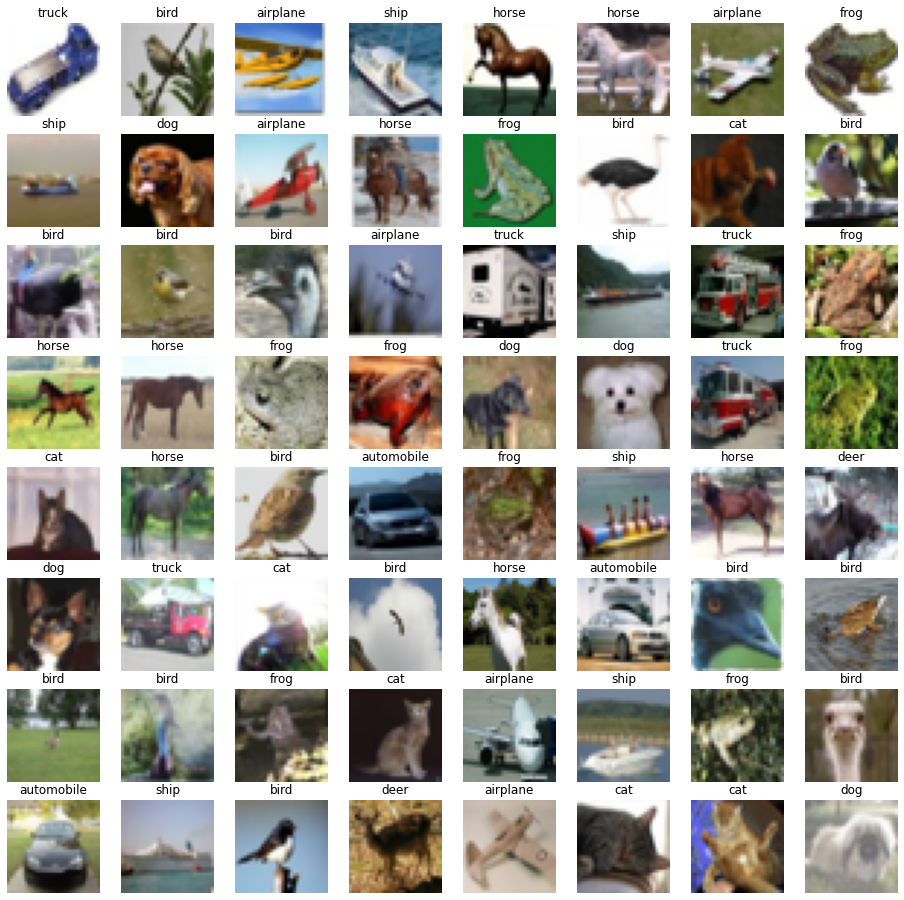

In [4]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

# plot some images
def plot_sample_images(preprocess_fn=None, nrows=4, ncols=4):
    fig, axs = plt.subplots(nrows, ncols,
                            figsize=(16,16)
                           )
    axs = axs.ravel() # make 1D array for easy plotting in for loop

    for i, image_id in enumerate(np.random.randint(x_train.shape[0], size=nrows*ncols)):
        # show an image
        img = x_train[image_id]

        if preprocess_fn:
            img = preprocess_fn(img)
        axs[i].imshow(img)
        axs[i].axis(False)
        label = labels[y_train[image_id].item()]
#         label = df_train.loc[:, 'healthy':].iloc[image_id, :].idxmax()
        axs[i].set_title('{}'.format(label))
plot_sample_images(nrows=8, ncols=8)

## Pre-processing

In [5]:
# scale data
x_train, x_val = x_train / 255.0, x_val / 255.0

# inspect shape and type
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_val.dtype, y_train.dtype

((50000, 32, 32, 3),
 (50000, 1),
 (10000, 32, 32, 3),
 (10000, 1),
 dtype('float64'),
 dtype('uint8'))

The labels of the Cifar10 images are stores as integer numbers. As the classification CNN has one output for every class, the labels need to be converted to a one-hot encoded vector.

<div align="center">
<a><img src="https://drive.google.com/uc?id=1TZWumlT60fwqoQYLJ-OD6e4-k_pymBep" width="400"></a>
</div>

In [6]:
# reformat labels to one-hot-encoded labels
print('Before y_train[0] = {}'.format(y_train[0]))
y_train = utils.to_categorical(y_train, 10)
y_val = utils.to_categorical(y_val, 10)
print('After y_train[0] = {}'.format(y_train[0]))

Before y_train[0] = [6]
After y_train[0] = [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


# Modeling
We are going to build a simple model with Keras Sequential API. 
A neural network can be build in two step. First the topology of the neural network is defined. The main building block of the CNN is the convolution layer. Lets have a look at the signature of the Conv2D class. Full documentation is available [here](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/layers/Conv2D).

```
tf.keras.layers.Conv2D(
    filters, kernel_size, strides=(1, 1), activation=None,
)

```
There are a lot of ways you can customize the layer. However, we are going to have a look at the most important parameters:
- **filters** - Number of filters to use in the convolution layer. Defines the number of "channels" in the output tensor.
- **kernel_size** - Tuple specifying the width and height of the convolution filter.
- **stride** - The step size at which the kernel moves across image.
- **activation** - The activation function applied on the output of the layer.


<div align="center">
<a><img src="https://drive.google.com/uc?id=1RiaJ1yi8GEdQSsu_dXN66mEr0eQEdJz4" width="700"></a>
</div>


## Model Architecture

In [7]:
# define model topology
model = models.Sequential()
model.add(layers.Conv2D(16, (3,3), activation='relu', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(32, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

# define model optimization method
model.compile(optimizer=optimizers.Adam(lr=0.001), 
              loss='categorical_crossentropy', 
              metrics=['categorical_accuracy'])

In [8]:
# print model information
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 32)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 128)               0

## Training

In [9]:
history = model.fit(x_train, y_train, epochs=50, batch_size=64, validation_data=(x_val, y_val))

Epoch 1/50
782/782 [==============================] - 3s 4ms/step - loss: 1.7541 - categorical_accuracy: 0.3476 - val_loss: 1.5436 - val_categorical_accuracy: 0.4393
Epoch 2/50
782/782 [==============================] - 3s 4ms/step - loss: 1.4333 - categorical_accuracy: 0.4821 - val_loss: 1.4084 - val_categorical_accuracy: 0.4887
Epoch 3/50
782/782 [==============================] - 2s 3ms/step - loss: 1.3261 - categorical_accuracy: 0.5256 - val_loss: 1.2981 - val_categorical_accuracy: 0.5337
Epoch 4/50
782/782 [==============================] - 3s 4ms/step - loss: 1.2479 - categorical_accuracy: 0.5549 - val_loss: 1.2122 - val_categorical_accuracy: 0.5673
Epoch 5/50
782/782 [==============================] - 2s 3ms/step - loss: 1.1859 - categorical_accuracy: 0.5806 - val_loss: 1.1859 - val_categorical_accuracy: 0.5791
Epoch 6/50
782/782 [==============================] - 3s 4ms/step - loss: 1.1314 - categorical_accuracy: 0.5982 - val_loss: 1.1668 - val_categorical_accuracy: 0.5854
Epoc

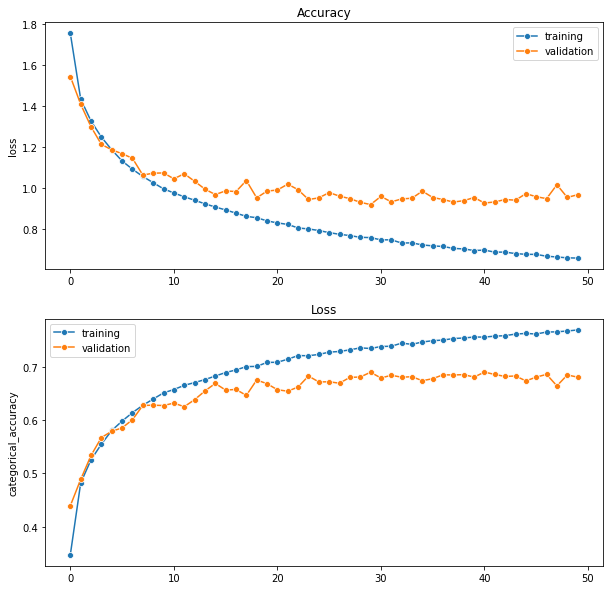

In [10]:
def visualize_training_process(history):
    """ 
    Visualize loss and accuracy from training history
    
    :param history: A Keras History object
    """
    fig, axs = plt.subplots(2, 1, figsize=(10,10))
    axs = axs.ravel() # make 1D array for easy plotting in for loop

    df = pd.DataFrame(history.history)
    
    axs[0].set_title('Accuracy')    
    sns.lineplot(data=df, x=df.index, y='loss', ax=axs[0], label='training', marker='o')
    sns.lineplot(data=df, x=df.index, y='val_loss', ax=axs[0], label='validation', marker='o')
    
    axs[1].set_title('Loss')
    sns.lineplot(data=df, x=df.index, y='categorical_accuracy', ax=axs[1], label='training', marker='o')
    sns.lineplot(data=df, x=df.index, y='val_categorical_accuracy', ax=axs[1], label='validation', marker='o')
    plt.show()
    
visualize_training_process(history)

In [17]:
print('Final Training Accuracy: {:.4f}'.format(history.history['categorical_accuracy'][-1]))
print('Final Validation Accuracy: {:.4f}'.format(history.history['val_categorical_accuracy'][-1]))
print('Final Training Loss: {:.4f}'.format(history.history['loss'][-1]))
print('Final Validation Loss: {:.4f}'.format(history.history['val_loss'][-1]))

Final Training Accuracy: 0.7693
Final Validation Accuracy: 0.6807
Final Training Loss: 0.6573
Final Validation Loss: 0.9666


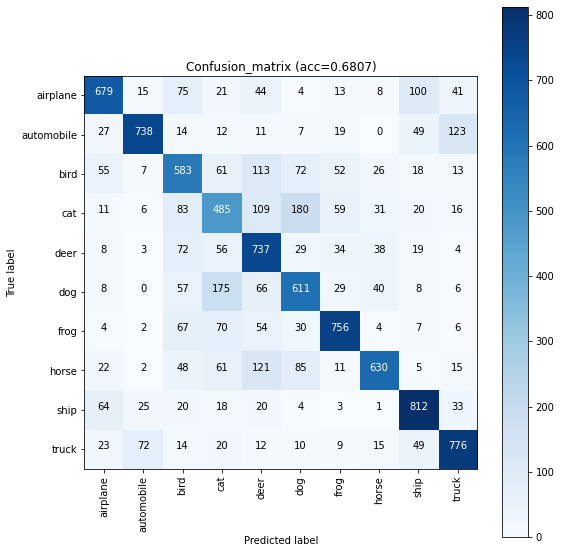

In [16]:
# Evaluate performance of model by plotting confusion matrix
from sklearn.metrics import confusion_matrix

# see http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools

def accuracy(y, y_pred):
    return np.sum(y==y_pred)/len(y)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(8, 8))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    plt.grid(False)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')   
    
# predict labels from validation set
y_pred = model.predict(x_val)

# convert data to label number
y_pred = np.argmax(y_pred, axis=1) 
y_true = np.argmax(y_val, axis=1) 

# compute the confusion matrix
cm = confusion_matrix(y_true, y_pred) 
    
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
plot_confusion_matrix(cm, labels, title='Confusion_matrix (acc={})'.format(accuracy(y_true, y_pred)))  


# Exercise

Improve the current CNN performance! Knobs to tune include:

- adjust hyper-parameters such as the optimizer, learning rate, batch size
- change the CNN architecture
- add dropout and/or batch normalization layers
- checkpoint saving
- early stopping
- augment the data

You can find list of papers, code and performance scores on the Cifar10 at [this website](https://paperswithcode.com/sota/image-classification-on-cifar-10).